# Exercise 4: Short-time Fourier Transform



### Relevant Concepts

__Main lobe of the spectrum of a window:__
The width of the main lobe of the magnitude spectrum of a window is an important characteristic used in deciding which window type is best for the analysis of an audio excerpt. There exists a tradeoff between the main lobe width and the side lobe attenuation. Typically for windows with a narrower main lobe, the side lobes are less attenuated.
An interesting fact is that changing the length of a window $M$ doesn't affect the main lobe width of the spectrum of the window in samples. Note that if you use zero-padding for computing the spectrum of a window, the main lobe width will be multiplied by the zero-padding factor.

__Fast Fourier Transform (FFT):__
An efficient way to compute the discrete Fourier transform of a signal is the fast Fourier transform, FFT. The FFT algorithm  factorizes the DFT matrix in order to exploit the symmetries in the DFT equation. FFT computation is specially very efficient when the FFT size is a power of 2. Therefore, whenever possible we use an FFT size that is a power of 2.

__Energy of a signal:__ The energy of a signal $x[n]$ of length $N$ can be computed in the discrete time domain as follows:
\begin{equation}
E=\overset{N-1}{\underset{n=0}{\sum}}\left|x\left[n\right]\right|^{2}
\end{equation}

__Energy in a frequency band:__ Given the DFT spectrum of the signal $X[k]$, the energy $E$ in a specific frequency band spanning the bin index $k_1$ to $k_2$ can be computed as:

\begin{equation}
E=\overset{k_{2}}{\underset{k=k_{1}}{\sum}}\left|X\left[k\right]\right|^{2}
\end{equation}

Note that in this computation the $X[k]$ values are not in decibels (dB). The `stftAnal()` function returns magnitude spectra in dB scale, which should be converted to linear scale before the energy computation. Once the energy is computed it can be converted back to the dB scale as:

\begin{equation}
E_{dB}= 10\,\log_{10}(E)
\end{equation}

__Signal to noise ratio (SNR):__
Signal to noise ratio (SNR) is a frequently used measure to quantify the amount of noise present/added in a signal. In the context of this exercise it can be computed in decibels (dB) as:

\begin{equation}
\mathrm{SNR} = 10\,\log_{10}\left(\frac{E_{\mathrm{signal}}}{E_{\mathrm{noise}}}\right)
\end{equation}

where, $E_{\mathrm{signal}}$ and $E_{\mathrm{noise}}$ are the energy of the signal and noise respectively.

For our case of analysis and synthesis using a specific model (for example, STFT) noise can be thought of as the difference between the input signal and the output signal of the model.

__Onset detection function:__
An onset detection function (ODF) refers to a continuous function (one value per audio frame) often used for detecting acoustic events in an audio stream. In music information retrieval (MIR), ODFs are typically used for detecting onsets of musical notes and percussion strokes. An ODF generally has high values at the onsets of acoustic events. A simple ODF can be computed by taking the difference between the energy values of consecutive frames, as shown below:

\begin{equation}
O(l) = E(l) - E(l-1) ,\,\,\,\,\, l \geq 1
\end{equation}

where, $O(l)$ is the ODF computed at frame index $l$ and $E$ is the energy of the signal in a particular frequency band in decibels (dB). Often, multiple ODFs are computed with different frequency bands across the spectrum.

In order to detect only the onsets of the events and not the offsets, it is a common practice to half wave rectify the ODF and obtain $\bar{O}(l)$. Half wave rectification of the ODF is given by:

 \begin{equation}
 \bar{O}(l)=\begin{cases}
 \begin{array}{c}
 O(l), \, \mathrm{if} \,\,O(l)>0\\
 \,\,\,\,0, \,\,\,\,\, \mathrm{if} \,\, O(l)\leq0
 \end{array}\end{cases}
 \end{equation}

## Part 1 - Extracting the main lobe of the spectrum of a window

The function `extract_main_lobe()` extracts the main lobe of the magnitude spectrum of a window given a window type, `window`, and its length, `M`. The function returns the samples corresponding to the main lobe in decibels (dB).

To compute the spectrum we take the FFT size (`N`) to be 8 times the window length (`N = 8*M`) (For this part, `N` does not need to be a power of 2).

The input arguments to the function are the window type (`window`) and the length of the window (`M`). The function returns a numpy array containing the samples corresponding to the main lobe of the window. In the returned numpy array includes the samples corresponding to both the local minimas across the main lobe.

The possible window types that you can expect as input are rectangular (`'boxcar'`), `'hamming'` or `'blackmanharris'`.




In [3]:
import numpy as np
from scipy.signal import get_window
from scipy.fftpack import fft, fftshift

eps = np.finfo(float).eps
from smstools.models import stft
from smstools.models import utilFunctions as UF

In [ ]:

from scipy.signal import get_window, argrelextrema
def extract_main_lobe(window, M, N):
    """Extract the main lobe of the magnitude spectrum of a window, given a window type and its length.

    Args:
        window (str): Window type to be used (either rectangular ('boxcar'), 'hamming' or 'blackmanharris')
        M (int): length of the window to be used
        N (int): size of FFT

    Results:
        np.array: an array containing the main lobe of the magnitude spectrum of the window in decibels (dB).
    """

    
    # Generate the window
    w = get_window(window, M)
    
    # Compute the FFT of the window
    W = fft(w, N)
    
    # Compute magnitude spectrum in dB, avoiding log(0)
    mag_spectrum = 20 * np.log10(np.abs(W) + 1e-16)
    
    # Center the spectrum using fftshift
    mag_spectrum = fftshift(mag_spectrum)
    
    # Find the peak (main lobe center)
    peak_idx = np.argmax(mag_spectrum)
    
    # Find local minima around the main lobe
    minima_indices = argrelextrema(mag_spectrum, np.less)[0]
    
    # Find the first minima before and after the peak
    left_min_idx = minima_indices[minima_indices < peak_idx][-1]
    right_min_idx = minima_indices[minima_indices > peak_idx][0]
    
    # Extract the main lobe
    main_lobe = mag_spectrum[left_min_idx:right_min_idx + 1]
    
    return main_lobe, left_min_idx, right_min_idx, mag_spectrum

Window: blackmanharris, M: 100, Main Lobe Length: 65
Normalized Main Lobe Width for blackmanharris: 8.12



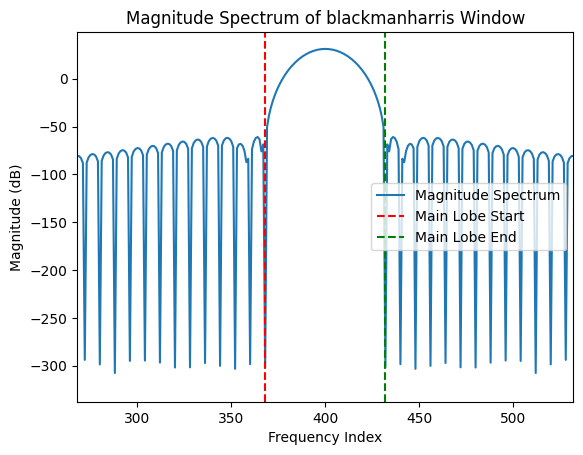

Window: boxcar, M: 120, Main Lobe Length: 17
Normalized Main Lobe Width for boxcar: 2.12



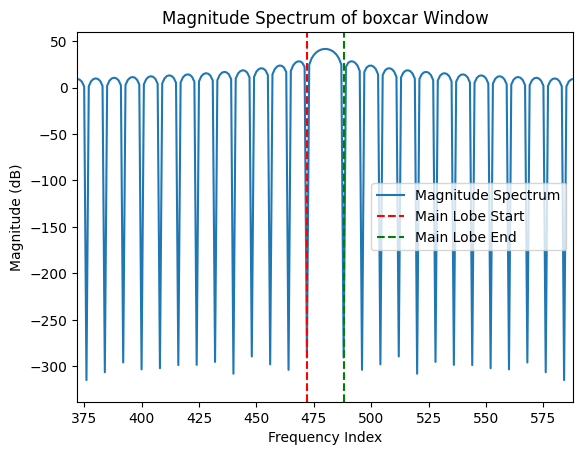

Window: hamming, M: 256, Main Lobe Length: 33
Normalized Main Lobe Width for hamming: 4.12



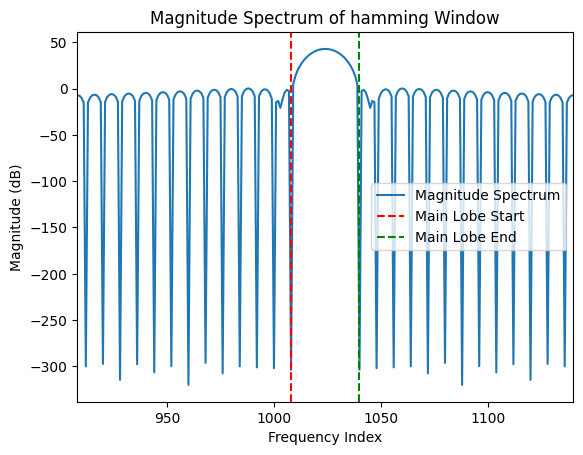

In [ ]:

import matplotlib.pyplot as plt

test_cases = [
    ('blackmanharris', 100, 800),
    ('boxcar', 120, 960),
    ('hamming', 256, 2048)
]

for window, M, N in test_cases:
    main_lobe, left_idx, right_idx, mag_spectrum = extract_main_lobe(window, M, N)
    output_len = len(main_lobe)
    
    print(f"Window: {window}, M: {M}, Main Lobe Length: {output_len}")
    
    # Compute zero-padding factor
    zero_padding_factor = (8 * M) / M  # N/M = 8
    normalized_width = output_len / zero_padding_factor
    print(f"Normalized Main Lobe Width for {window}: {normalized_width:.2f}\n")
    
    # Plot magnitude spectrum with main lobe boundaries
    plt.figure()
    plt.plot(mag_spectrum, label="Magnitude Spectrum")
    plt.axvline(x=left_idx, color='r', linestyle='--', label='Main Lobe Start')
    plt.axvline(x=right_idx, color='g', linestyle='--', label='Main Lobe End')
    plt.legend()
    plt.title(f"Magnitude Spectrum of {window} Window")
    plt.xlabel("Frequency Index")
    plt.xlim(left_idx - 100, right_idx + 100)
    plt.ylabel("Magnitude (dB)")
    plt.show()


In this task I analyzed the main-lobe width of different functions by computing their  magnitude spectra and normalizing the main-lobe width using the zero-padding factor (to make it independent of the FFT size).
The normalized width of each of the different types of window coincide approximately with the values presented in theory.

Blackman-Harris Window (8.12): This window has the widest main lobe, indicating poor frequency resolution but excellent spectral leakage suppression due to its very low side lobes.

Boxcar (Rectangular) Window (2.12): This window has the narrowest main lobe, providing the best frequency resolution but at the cost of high side lobes, leading to significant spectral leakage.

Hamming Window (4.12): This window is a compromise between the two, with moderate main-lobe width and reduced side lobes, offering a balance between frequency resolution and leakage suppression.



## Part 2 - Measuring noise in the reconstructed signal using the STFT model

The function `compute_snr()` measures the amount of distortion introduced during the analysis and synthesis of a signal using the STFT model. Use SNR (signal to noise ratio) in dB to quantify the amount of noise.
Use the `stft()` function in `stft.py` to do an analysis followed by a synthesis of the input signal.

Use the time domain energy definition to compute the SNR. With the input signal and the obtained output, compute two different SNR values for the following cases:

1. `SNR1`: Over the entire length of the input and the output signals.
2. `SNR2`: For the segment of the signals left after discarding `M` samples from both the start and the end, where `M` is the analysis window length.

Note that the computations are done after STFT analysis and synthesis. The input arguments to the function are the wav file name including the path (`input_file`), window  type (`window`), window length (`M`), FFT size (`N`), and hop size (`H`). The function returns a python tuple of both the SNR values in decibels. Both SNR1 and SNR2 are float values.

In [6]:

import scipy.io.wavfile as wav

from stft import stft

def compute_snr(input_file, window, M, N, H):
    """Measure the amount of distortion introduced during the analysis and synthesis of a signal using the STFT model.

    Args:
        input_file (str): wav file name including the path
        window (str): analysis window type (rectangular, triangular, hanning, hamming, blackman, or blackmanharris)
        M (int): analysis window length (odd positive integer)
        N (int): fft size (power of two, > M)
        H (int): hop size for the stft computation

    Result:
        tuple with the signal to noise ratio over the whole sound and of the sound without the begining and end.
    """
    
    # 1. Load the audio file
    sample_rate, x = wav.read(input_file)
    x = x / np.max(np.abs(x))

    w = get_window(window, M)
    # 3. Perform STFT analysis and synthesis
    y = stft(x, w, N, H)

    # 4. Compute SNR1 (Signal-to-Noise Ratio over the entire signal)
    energy_input = np.sum(x ** 2)  # total energy of the input signal
    energy_noise = np.sum((x - y) ** 2)  # noise energy (input - output)
    
    # Compute SNR1 in dB
    snr1 = 10 * np.log10(energy_input / energy_noise)

    # 5. Compute SNR2 (SNR over the portion of the signal excluding the first and last M samples)
    x_trimmed = x[M:-M]  # discard M samples from the start and end
    y_trimmed = y[M:-M]  # discard M samples from the start and end
    
    energy_input_trimmed = np.sum(x_trimmed ** 2)
    energy_noise_trimmed = np.sum((x_trimmed - y_trimmed) ** 2)
    
    # Compute SNR2 in dB
    snr2 = 10 * np.log10(energy_input_trimmed / energy_noise_trimmed)
    
    # Return both SNR values
    return snr1, snr2


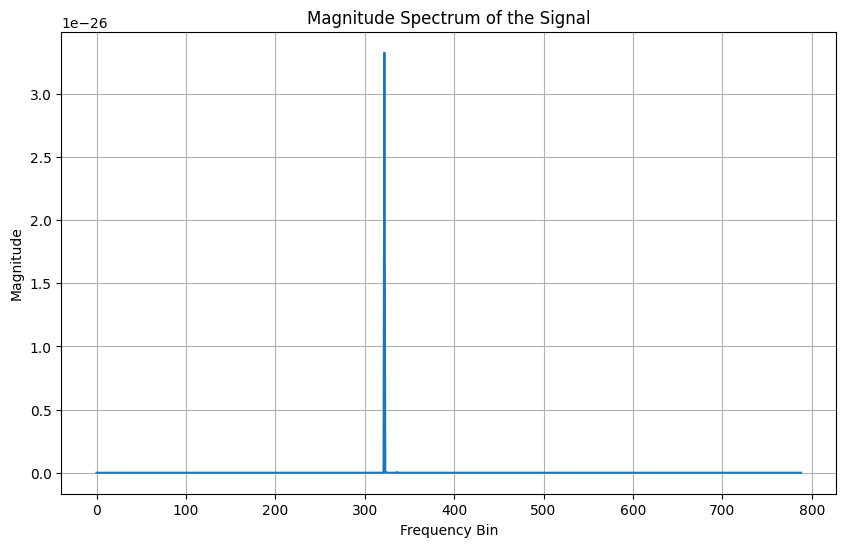

In [34]:
from stft import stftAnal
H = 215
M = 512
N = 2048
input_file = 'piano (1).wav'
window = 'hann'
sample_rate, x = wav.read(input_file)
x = x / np.max(np.abs(x))

w = get_window(window, M)
    # 3. Perform STFT analysis and synthesis
y, _ = stftAnal(x, w, N, H)

y = 10**y/10

plt.figure(figsize=(10, 6))
plt.plot(np.abs(y[:, 0]))  # Plot magnitude of the first STFT frame
plt.xlabel('Frequency Bin')
plt.ylabel('Magnitude')
plt.title('Magnitude Spectrum of the Signal')
plt.grid()
plt.show()

In [ ]:

window1 = "blackman"
M1 = 513
N1 = 2048
H1 = 128
snr1_case1, snr2_case1 = compute_snr("piano (1).wav", window1, M1, N1, H1)
print(f"Test Case 1 (Blackman, M={M1}, N={N1}, H={H1}):")
print(f"  SNR1 (Full Signal): {snr1_case1} dB")
print(f"  SNR2 (Trimmed Signal): {snr2_case1} dB")
print("\n")

window2 = "hamming"
M2 = 512
N2 = 1024
H2 = 64
snr1_case2, snr2_case2 = compute_snr("sax-phrase-short.wav", window2, M2, N2, H2)
print(f"Test Case 2 (Hamming, M={M2}, N={N2}, H={H2}):")
print(f"  SNR1 (Full Signal): {snr1_case2} dB")
print(f"  SNR2 (Trimmed Signal): {snr2_case2} dB")
print("\n")

window3 = "hann"
M3 = 1024
N3 = 2048
H3 = 128
snr1_case3, snr2_case3 = compute_snr("rain.wav", window3, M3, N3, H3)
print(f"Test Case 3 (Hanning, M={M3}, N={N3}, H={H3}):")
print(f"  SNR1 (Full Signal): {snr1_case3} dB")
print(f"  SNR2 (Trimmed Signal): {snr2_case3} dB")


Test Case 1 (Blackman, M=513, N=2048, H=128):
  SNR1 (Full Signal): 67.54018500096917 dB
  SNR2 (Trimmed Signal): 86.35716138846469 dB


Test Case 2 (Hamming, M=512, N=1024, H=64):
  SNR1 (Full Signal): 89.51050658170826 dB
  SNR2 (Trimmed Signal): 306.42860632565026 dB


Test Case 3 (Hanning, M=1024, N=2048, H=128):
  SNR1 (Full Signal): 74.63147605906214 dB
  SNR2 (Trimmed Signal): 305.52735619038333 dB



In **Test Case 1** with Blackman window (M=513, N=2048, H=128), the SNR1 for the full signal is 67.54 dB, meaning there’s some noticeable distortion from the Hanning window. However, the SNR2 for the trimmed signal improves significantly to 86.36 dB, indicating that removing the edges where windowing artifacts are more prominent helps clean up the signal.

**Test Case 2**, using the Hamming window (M=512, N=1024, H=64), shows a high SNR1 of 89.51 dB, suggesting the Hamming window does a good job of preserving the signal. The trimmed SNR2 is extremely high at 306.43 dB, which likely means that after trimming the edges, there is almost no noise left in the central part of the signal.

In **Test Case 3** with the Hanning window (M=1024, N=2048, H=128), the SNR1 is 74.63 dB, reflecting moderate distortion, similar to Test Case 1. But after trimming, the SNR2 jumps to 305.53 dB, showing that the central portion of the signal is nearly perfectly reconstructed.

Overall, the window choice has a noticeable impact on the SNR. The Hamming and Hanning windows, offer better frequency resolution and signal preservation. Larger windows (like M=1024) give better frequency resolution but might introduce more edge artifacts, which trimming can effectively reduce. The hop size and FFT size also play a role,  smaller hop sizes and larger FFT sizes help to improve the quality of the reconstruction.

## Part 3 - Computing band-wise energy envelopes of a signal

The function `compute_eng_env()` compute sband-wise energy envelopes of a given audio signal using the STFT.

Consider two frequency bands, low and high. The low frequency band is the set of frequencies between 0 and 3000 Hz and the high frequency band is the set of frequencies between 3000 and 10000 Hz (excluding the boundary frequencies in both the cases). At a given frame, the value of the energy envelope of a band can be computed as the sum of squared values of all the frequency coefficients in that band. Then we compute the energy envelopes in decibels.

The input arguments are the wav file name including the path (`input_file`), window type (`window`), window length (`M`), FFT size (`N`) and hop size (`H`). The function returns a numpy array with two columns, where the first column is the energy envelope of the low frequency band and the second column is that of the high frequency band.

Use `stftAnal()` function from `stft.py` module to obtain the magnitude spectra for all the audio frames of the input sound. Then compute the energy values for each frequency band specified. While calculating frequency bins for each frequency band, consider only the bins that are within the specified frequency range. For example, for the low frequency band consider only the bins with frequency > 0 Hz and < 3000 Hz. This way you also remove the DC offset of the signal in energy envelope computation. The frequency corresponding to the bin index `k` can be computed as `k*fs/N`, where `fs` is the sampling rate of the signal.

In [9]:
import numpy as np
from scipy.io import wavfile
from stft import stftAnal 

def compute_eng_env(input_file, window, M, N, H):
    """Compute band-wise energy envelopes of a given audio signal using the STFT.

    Args:
        input_file (string): input sound file (monophonic with sampling rate of 44100)
        window (string): analysis window type (choice of rectangular, triangular, hanning,
                hamming, blackman, blackmanharris)
        M (integer): analysis window size (odd positive integer)
        N (integer): FFT size (power of 2, such that N > M)
        H (integer): hop size for the stft computation

    Result:
        np.array: 2D numpy array with energy envelope of band 0 < f < 3000 Hz (in dB) in first column, [:,0]
        np.array: energy envelope of band 3000 < f < 10000 Hz (in dB) in second column [:,1]
    """
    # Load audio signal
    fs, x = UF.wavread(input_file)

    w = get_window(window, M)

    xmX, _ = stftAnal(x, w, N, H)

    xmX_linear = 10 ** (xmX / 20)

    freqs = np.arange(N) * fs / N

    low_freq_indx = np.where((freqs > 0) & (freqs < 3000))[0]
    E_freq_low = np.sum(xmX_linear[:, low_freq_indx] ** 2, axis = 1)
    print('The bin indexes for low frequencies band spand go from', low_freq_indx[0], 'to', low_freq_indx[-1])

    high_freq_indx = np.where((freqs > 3000) & (freqs < 10000))[0]
    E_freq_high = np.sum(xmX_linear[:, high_freq_indx] ** 2, axis = 1)
    print('The bin indexes for high frequencies band spand go from', high_freq_indx[0], 'to', high_freq_indx[-1])
   
    # Convert energy to decibels
    E_low_dB = 10 * np.log10(E_freq_low + eps)
    E_high_dB = 10 * np.log10(E_freq_high + eps)

 
    # Combine both envelopes into one array
    energy_envelopes = np.vstack([E_low_dB, E_high_dB]).T

    return energy_envelopes, xmX_linear


The bin indexes for low frequencies band spand go from 1 to 69
The bin indexes for high frequencies band spand go from 70 to 232


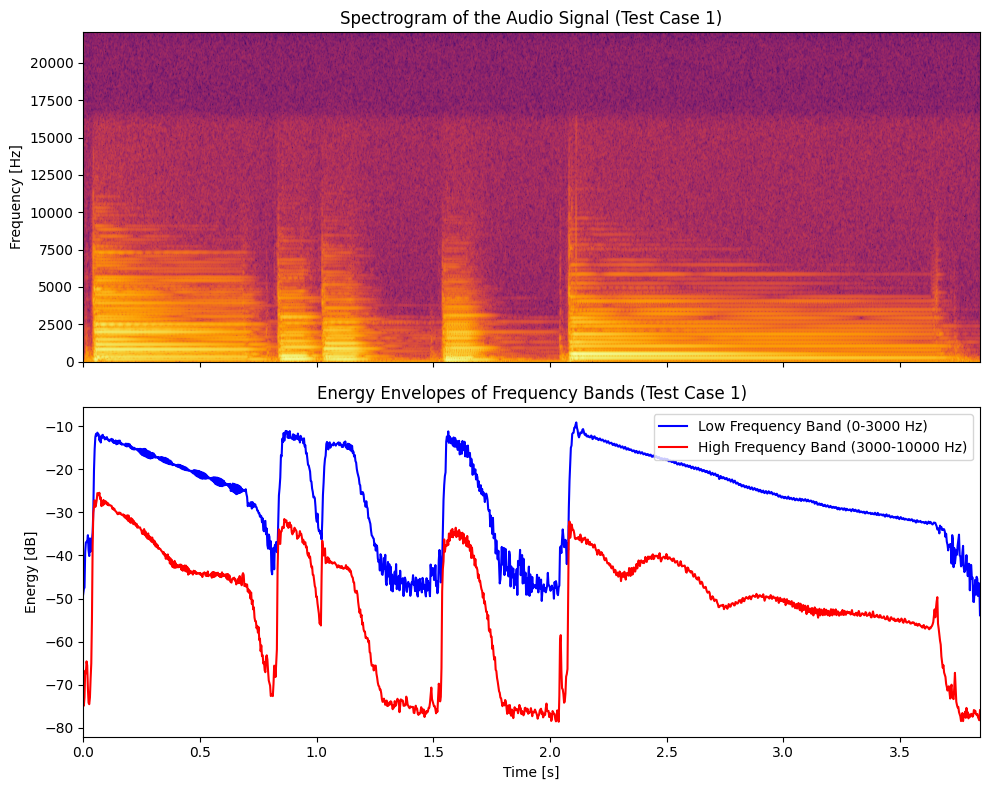

In [10]:

# Compute the energy envelopes for test case 1
energy_envelopes_1, magnitude_spectra_1 = compute_eng_env('piano (1).wav', 'blackman', 513, 1024, 128)

# Load the audio signal for the spectrogram
fs_1, signal_1 = wavfile.read('piano (1).wav')

# Plotting the spectrogram and energy envelopes for test case 1
time_axis_1 = np.arange(magnitude_spectra_1.shape[0]) * 128 / fs_1

# Create figure and axes for plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot the spectrogram
ax[0].imshow(20 * np.log10(np.abs(magnitude_spectra_1) + eps).T, aspect='auto', cmap='inferno', origin='lower', extent=[0, time_axis_1[-1], 0, fs_1/2])
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_title('Spectrogram of the Audio Signal (Test Case 1)')

# Plot the energy envelopes
ax[1].plot(time_axis_1, energy_envelopes_1[:,0], label='Low Frequency Band (0-3000 Hz)', color='blue')
ax[1].plot(time_axis_1, energy_envelopes_1[:,1], label='High Frequency Band (3000-10000 Hz)', color='red')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Energy [dB]')
ax[1].legend()
ax[1].set_title('Energy Envelopes of Frequency Bands (Test Case 1)')

plt.tight_layout()
plt.show()


The bin indexes for low frequencies band spand go from 1 to 278
The bin indexes for high frequencies band spand go from 279 to 928


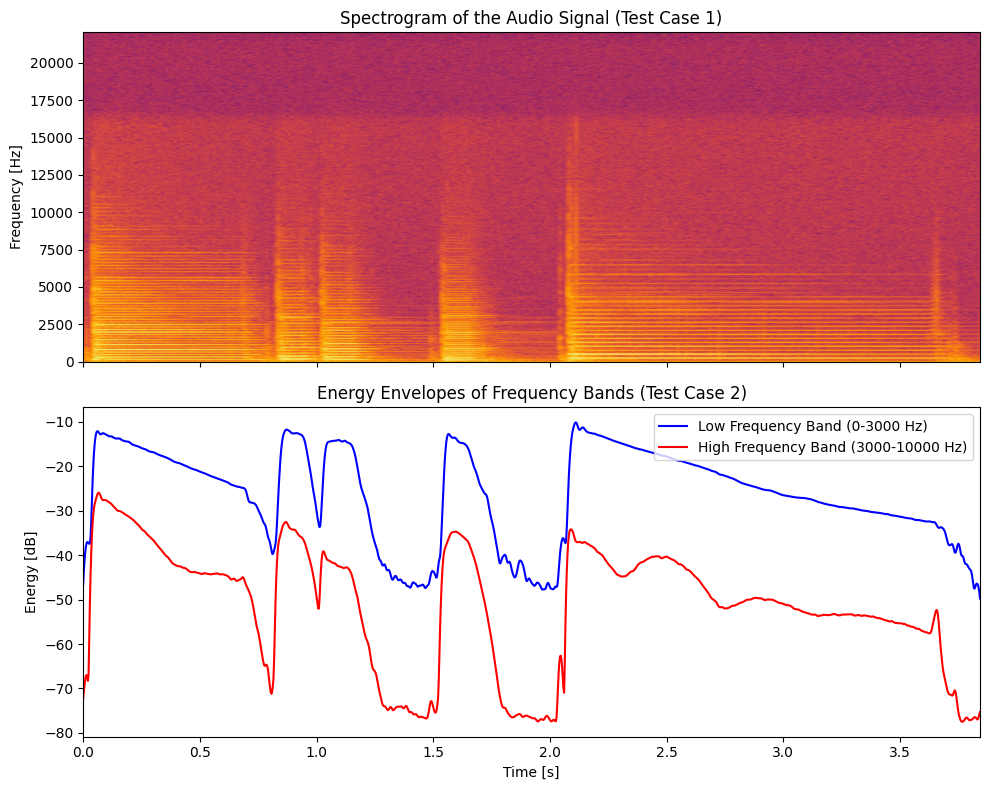

In [11]:


# Compute the energy envelopes for test case 1
energy_envelopes_1, magnitude_spectra_1 = compute_eng_env('piano (1).wav', 'blackman', 2047, 4096, 128)

# Load the audio signal for the spectrogram
fs_1, signal_1 = wavfile.read('piano (1).wav')

# Plotting the spectrogram and energy envelopes for test case 1
time_axis_1 = np.arange(magnitude_spectra_1.shape[0]) * 128 / fs_1

# Create figure and axes for plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot the spectrogram
ax[0].imshow(20 * np.log10(np.abs(magnitude_spectra_1) + eps).T, aspect='auto', cmap='inferno', origin='lower', extent=[0, time_axis_1[-1], 0, fs_1/2])
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_title('Spectrogram of the Audio Signal (Test Case 1)')

# Plot the energy envelopes
ax[1].plot(time_axis_1, energy_envelopes_1[:, 0], label='Low Frequency Band (0-3000 Hz)', color='blue')
ax[1].plot(time_axis_1, energy_envelopes_1[:, 1], label='High Frequency Band (3000-10000 Hz)', color='red')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Energy [dB]')
ax[1].legend()
ax[1].set_title('Energy Envelopes of Frequency Bands (Test Case 2)')

plt.tight_layout()
plt.show()


The bin indexes for low frequencies band spand go from 1 to 139
The bin indexes for high frequencies band spand go from 140 to 464


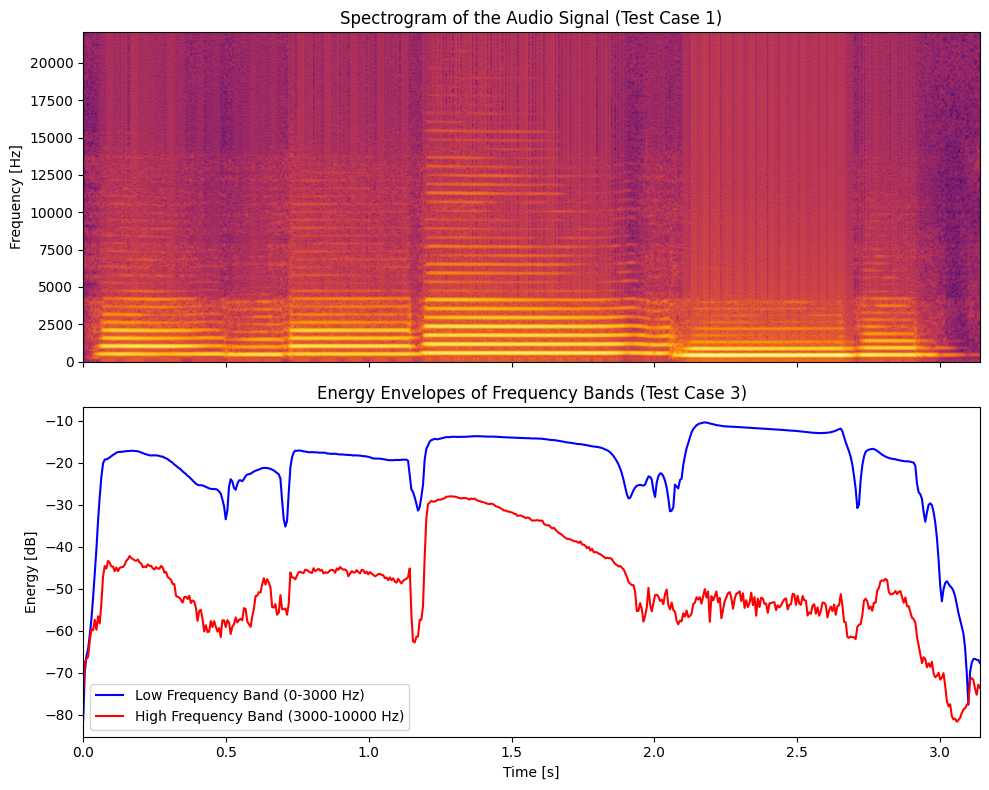

In [12]:


# Compute the energy envelopes for test case 1
energy_envelopes_1, magnitude_spectra_1 = compute_eng_env('sax-phrase-short.wav', 'hamming', 513, 2048, 256)

# Load the audio signal for the spectrogram
fs_1, signal_1 = wavfile.read('sax-phrase-short.wav')

# Plotting the spectrogram and energy envelopes for test case 1
time_axis_1 = np.arange(magnitude_spectra_1.shape[0]) * 256 / fs_1

# Create figure and axes for plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot the spectrogram
ax[0].imshow(20 * np.log10(np.abs(magnitude_spectra_1) + eps).T, aspect='auto', cmap='inferno', origin='lower', extent=[0, time_axis_1[-1], 0, fs_1/2])
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_title('Spectrogram of the Audio Signal (Test Case 1)')

# Plot the energy envelopes
ax[1].plot(time_axis_1, energy_envelopes_1[:, 0], label='Low Frequency Band (0-3000 Hz)', color='blue')
ax[1].plot(time_axis_1, energy_envelopes_1[:, 1], label='High Frequency Band (3000-10000 Hz)', color='red')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Energy [dB]')
ax[1].legend()
ax[1].set_title('Energy Envelopes of Frequency Bands (Test Case 3)')

plt.tight_layout()
plt.show()


## Part 4 - Computing onset detection function

The function `compute_odf()` computes a simple onset detection function (ODF) using the STFT. It computes two ODFs one for each of the frequency bands, low and high. The low frequency band is the set of all the frequencies between 0 and 3000 Hz and the high frequency band is the set of all the frequencies between 3000 and 10000 Hz (excluding the boundary frequencies in both the cases).

Start with an initial condition of `ODF(0) = 0` in order to make the length of the ODF same as that of the energy envelope. Remember to apply a half wave rectification on the ODF.

The input arguments to the function are the wav file name including the path (`input_file`), window
type (`window`), window length (`M`), FFT size (`N`), and hop size (`H`). The function returns a numpy
array with two columns, where the first column is the ODF computed on the low frequency band and the
second column is the ODF computed on the high frequency band.

Use `stftAnal()` to obtain the magnitude spectra for all the audio frames. Then compute the band-wise energy envelope for each frequency band specified. Finally compute the half wave rectify version of ODF from each energy envelope.


In [ ]:


from stft import stftAnal
def compute_odf(input_file, window, M, N, H):
    """Compute a simple onset detection function (ODF) using the STFT.

    Args:
        input_file (str): input sound file (monophonic with sampling rate of 44100)
        window (str): analysis window type (rectangular, triangular, hanning, hamming, blackman, or blackmanharris)
        M (int): analysis window size (odd integer value)
        N (int): fft size (power of two, bigger or equal than than M)
        H (int): hop size for the STFT computation

    Result:
            np.array: magnitude spectra of sound (2D array)
            np.array: D numpy array with ODF computed in band 0 < f < 3000 Hz (in dB) in first column, [:,0]
            np.array: ODF computed of band 3000 < f < 10000 Hz (in dB) in second column [:,1]
    """
    
    fs, x = UF.wavread(input_file)

    w = get_window(window, M)

    xmX, _ = stftAnal(x, w, N, H)

    xmX_linear = 10 ** (xmX / 20)

    freqs = np.arange(N) * fs / N

    low_freq_indx = np.where((freqs > 0) & (freqs < 3000))[0]
    E_freq_low = np.sum(xmX_linear[:, low_freq_indx] ** 2, axis = 1)
    

    high_freq_indx = np.where((freqs > 3000) & (freqs < 10000))[0]
    E_freq_high = np.sum(xmX_linear[:, high_freq_indx] ** 2, axis = 1)
   
    # Convert energy to decibels
    E_freq_low_dB = 10 * np.log10(E_freq_low + eps)
    E_freq_high_dB = 10 * np.log10(E_freq_high + eps)

    low_odf = np.diff(E_freq_low_dB, prepend=0)
    high_odf = np.diff(E_freq_high_dB, prepend=0)

    # Half-wave rectification (ensuring no negative ODF values)
    low_odf = np.maximum(0, low_odf)
    high_odf = np.maximum(0, high_odf)

    
    # Combine both ODFs into a single numpy array
    odf = np.vstack([low_odf, high_odf]).T

    return odf, xmX_linear


Test Case 1:


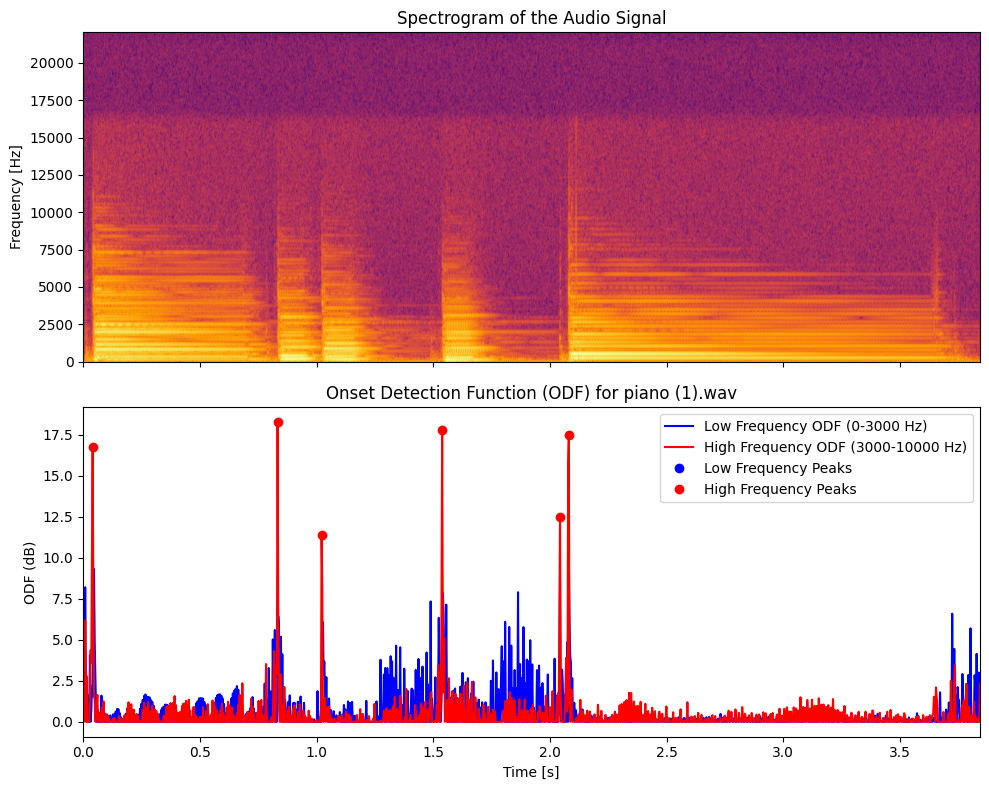

In [14]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import get_window, find_peaks
from scipy.io import wavfile

# Assume compute_odf() is already defined as provided earlier
def find_peaks_in_odf(odf, threshold):
    """Find peaks (local maxima) in the ODFs based on a threshold."""
    # Find peaks in the low and high-frequency ODFs using a threshold
    peaks_low, _ = find_peaks(odf[:, 0], height=threshold)
    peaks_high, _ = find_peaks(odf[:, 1], height=threshold)
    
    return peaks_low, peaks_high


def plot_spectrogram_and_odf(input_file, window, M, N, H, threshold):
    """Plot the spectrogram and ODFs for low and high frequency bands."""
    # Call the function to compute ODF
    odf, magnitude_spectra = compute_odf(input_file, window, M, N, H)

    # 
    fs, signal = wavfile.read(input_file)

    # Create a time axis for the plots
    time_axis = np.arange(magnitude_spectra.shape[0]) * H / fs

    peaks_low, peaks_high = find_peaks_in_odf(odf, threshold)


    # Create the plots
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot the spectrogram
    ax[0].imshow(20 * np.log10(np.abs(magnitude_spectra) + eps).T, aspect='auto', cmap='inferno', origin='lower', extent=[0, time_axis[-1], 0, fs/2])
    ax[0].set_ylabel('Frequency [Hz]')
    ax[0].set_title('Spectrogram of the Audio Signal')

    # Plot the ODF for low and high frequencies
    ax[1].plot(time_axis, odf[:, 0], label="Low Frequency ODF (0-3000 Hz)", color='blue')
    ax[1].plot(time_axis, odf[:, 1], label="High Frequency ODF (3000-10000 Hz)", color='red')
    ax[1].plot(time_axis[peaks_low], odf[peaks_low, 0], 'bo', label="Low Frequency Peaks")
    ax[1].plot(time_axis[peaks_high], odf[peaks_high, 1], 'ro', label="High Frequency Peaks")
    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel('ODF (dB)')

    ax[1].legend(loc='upper right')
    ax[1].set_title(f'Onset Detection Function (ODF) for {input_file}')

    # Tight layout for better spacing
    plt.tight_layout()
    plt.show()

    return odf

# Test Case 1: piano.wav, 'blackman', M=513, N=1024, H=128
print("Test Case 1:")
odf1 = plot_spectrogram_and_odf('piano (1).wav', 'blackman', M=513, N=1024, H=128, threshold=10)



Test Case 2:


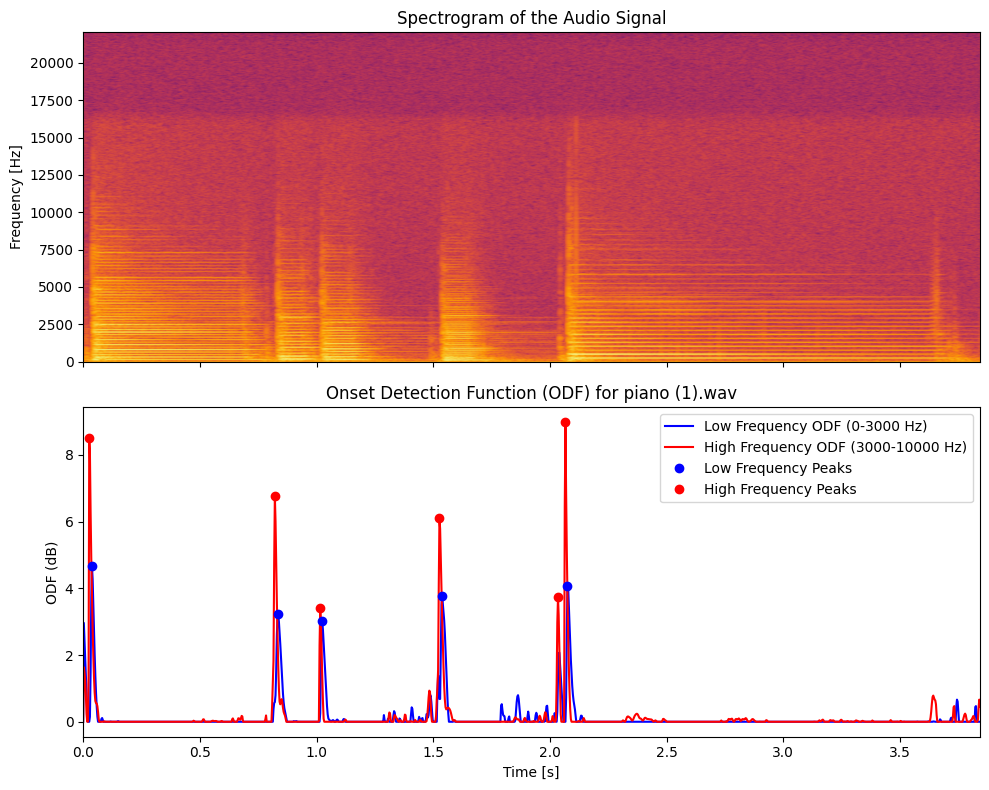

In [15]:
print("Test Case 2:")
odf1 = plot_spectrogram_and_odf('piano (1).wav', 'blackman', M=2047, N=4096, H=128, threshold=3)

Test Case 3:


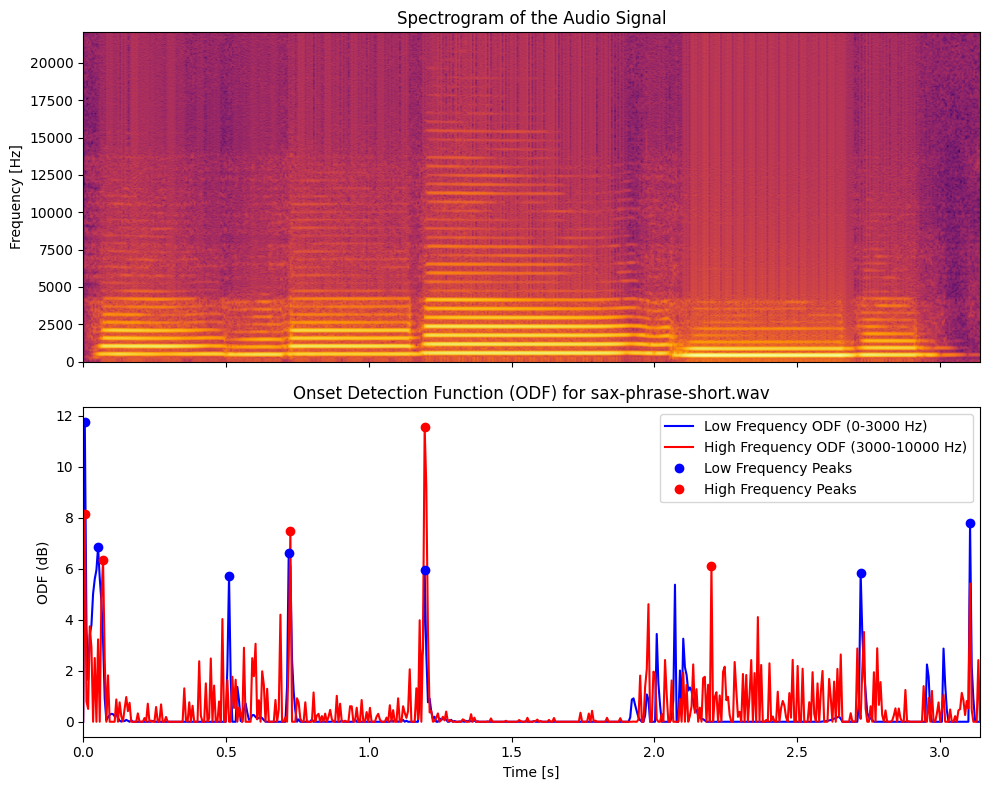

In [16]:
print("Test Case 3:")
odf1 = plot_spectrogram_and_odf('sax-phrase-short.wav', 'hamming', M=513, N=2048, H=256, threshold=5.5)



The high-frequency ODF (3000-10,000 Hz) is better for detecting note onsets because it has sharper, more distinct peaks. The low-frequency ODF (0-3,000 Hz) is smoother and less responsive to quick changes in sound. Since note attacks often have strong high-frequency components, the high-frequency ODF is more useful for onset detection.

Choosing the right threshold is important to separate real onsets from background noise. In the first case (piano signal), peaks in the high-frequency ODF are around 10-20 dB. In the second and third cases (saxophone phrase and piano sound), the peaks are slightly lower and there are more small peaks.

A good threshold would be around 5-10 dB to capture strong peaks while ignoring noise. However, a single fixed threshold may not work well for all cases. A better approach would be to use an adaptive threshold that adjusts based on the signal’s overall level. This would improve accuracy for different instruments.
